Copyright (C) 2024 Konstantin Touev  
All Rights Reserved.

TODO: Cite dataset https://huggingface.co/datasets/retkowski/ytseg

Do the imports -> we use the standard project imports as we verify project solutions 

In [1]:
import datetime
from IPython.display import display

from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

if __name__ == "__main__":
    from dotenv import load_dotenv

    load_dotenv()

import pandas as pd
from pandas import Timedelta
from langchain import PromptTemplate
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from file_processing.document_processor.summarisation_utils import chunk_into_semantic_chapters
from file_processing.embeddings import pending_embeddings_singleton, BGEM3Flag
from file_processing.llm_chat_support import get_llm, LLMTemp, LLMTypes

/u/halle/tou/home_at/IdeaProjects/thesis_backend/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare dataset and tools

In [5]:
import tiktoken

# First load the CSV
# Originally from https://huggingface.co/datasets/recapper/Course_summaries_dataset
# I choose this dataset as it had timestamped transcriptions and human-entered chapters for the videos

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
# Read the whole text fields
pd.set_option('display.max_colwidth', None)

yt_transcript_path = hf_hub_download(repo_type="dataset", repo_id="retkowski/ytseg", filename="data/yt_seg_titles.json")
data_df = pd.read_json(yt_transcript_path, orient='records', lines=True)

video_urls = data_df['video_id']

# 19 per group is calculated using power test for sample_size = 12
# H0 was already rejected, but using the suggested minimum sample size is good!
sample_size = round(19 * 2.5)
video_urls = video_urls.sample(n=sample_size*2).sort_values().tolist()

human_chapters_transcript_data = []
for video_url in video_urls:
    human_chapters_per_video_df = data_df[data_df['video_id'] == video_url]
    for _, row in human_chapters_per_video_df.iterrows():
        human_chapters_transcript_data.append({
            'video_url': video_url,
            'title': row['target'],
            'chapter_text': row['input']
        })
human_chapters_transcript_df = pd.DataFrame(human_chapters_transcript_data)

video_transcripts_df = human_chapters_transcript_df.groupby('video_url')['chapter_text'].apply(' '.join).reset_index()

encoding = tiktoken.encoding_for_model('gpt-4')
def get_token_count(text):
    return len(encoding.encode(text))

# Prevent transcripts overflowing GPT 4o - transcript + division A + division B => ~40k tokens per transcript
video_transcripts_df = video_transcripts_df[video_transcripts_df['chapter_text'].apply(get_token_count) <= 40_000]

print(
    f"Removed {len(video_urls) - len(video_transcripts_df['video_url'].unique().tolist())} videos from {sample_size * 2} sampled because transcript > 40k GPT 4o tokens!")

video_urls = video_transcripts_df['video_url'].sample(n=sample_size).sort_values().tolist()

print(f"We have {len(video_urls)} videos in dataset:")
display(pd.DataFrame({'VideoURL': video_urls[:]}))

video_transcripts_df = None

#print("Transcripts for video:")
#display(transcripts_df)
#print("Human chapters for video:")
#display(human_chapters_df)
print("Human chapters and their transcript per video:")
display(human_chapters_transcript_df)

# Define LLM-globals
class ScoreFormat(BaseModel):
    rating: int = Field(description="Rating from 0 to 100")
    arguments: str = Field(description="Arguments explaining why the rating was chosen")


structured_model = (get_llm(LLMTemp.CONCRETE, LLMTypes.BIG_VISUAL_MODEL)
                    .with_structured_output(ScoreFormat, method="json_mode"))

pending_embeddings_singleton.init_mode(BGEM3Flag())

output_parser = PydanticOutputParser(pydantic_object=ScoreFormat)

Removed 2 videos from 96 sampled because transcript > 40k GPT 4o tokens!
We have 48 videos in dataset:


,VideoURL
0,-U32Yl1nxgU
1,099IP8Wsqgc
2,1AYQBW11jXE
3,3MqJzMvHE3E
4,3Y9TaxwcQGs
5,4h_DpCFQ99w
6,65SvTs_b3RE
7,6jkN50X9gZc
8,7Pv-j_R3YP4
9,AJbZ4ojzbbI


Human chapters and their transcript per video:


video_url                                title  \
0     -RF5n5Og95s                                Intro   
1     -RF5n5Og95s                     Memory Bandwidth   
2     -RF5n5Og95s                     Power Management   
3     -RF5n5Og95s                 Channel Architecture   
4     -RF5n5Og95s                         Burst Length   
...           ...                                  ...   
1225  zrs7u6bdbUw      Adding Notification slice state   
1226  zrs7u6bdbUw            Using Redux Thunk Pattern   
1227  zrs7u6bdbUw    Creating Thunk Pattern with redux   
1228  zrs7u6bdbUw  Sending GET HTTP request with Redux   
1229  zrs7u6bdbUw                Summary of the course   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Fetching 30 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86243.40it/s]
/u/halle/tou/home_at/IdeaProjects/thesis_backend/venv/lib/python3.10/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` 

For evaluation, we do 4 things -> titles for semantic chapter, rate human titles, rate chapter division and evaluate semantic vs human chapters directly.

In [6]:
from langchain_experimental.text_splitter import SemanticChunker

original_semantic_chapter_df = pd.DataFrame(columns=['video_url', 'title', 'chapter_text'])

for video_url in list(video_urls):
    try:
        transcripts_video_df = human_chapters_transcript_df[
            (human_chapters_transcript_df['video_url'] == video_url)
        ]
        # Sometimes we have wrong datatype for transcript
        transcript_text = ' '.join(transcripts_video_df['chapter_text'].tolist())

        text_splitter = SemanticChunker(
            pending_embeddings_singleton, breakpoint_threshold_type="percentile"
        )

        # Use default chunk size
        original_semantic_chapters = text_splitter.split_text(transcript_text)

        original_semantic_chapter_per_video_data = []
        for idx, chapter_text in enumerate(original_semantic_chapters):
            original_semantic_chapter_per_video_data.append({
                'video_url': video_url,
                'title': '',
                'chapter_text': chapter_text
            })

        original_semantic_chapter_per_video_df = pd.DataFrame(original_semantic_chapter_per_video_data)
        # print(f"Semantic chapters and their transcripts for video '{video_url}':")
        # display(semantic_chapter_per_video_df)
        print(f"Original semantic chapters for video '{video_url}':")
        original_semantic_chapter_df = pd.concat([original_semantic_chapter_df, original_semantic_chapter_per_video_df]).reset_index(drop=True)
    except Exception as e:
        print(f"Failed to add video '{video_url}' semantic chapters")
        print(e)
        video_urls.remove(video_url)


print(f"Original semantic chapters and their transcript per video:")
display(original_semantic_chapter_df)

Original semantic chapters for video '-U32Yl1nxgU':
Original semantic chapters for video '099IP8Wsqgc':
Original semantic chapters for video '1AYQBW11jXE':


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:06<00:00, 39.48it/s]


Original semantic chapters for video '3MqJzMvHE3E':
Original semantic chapters for video '3Y9TaxwcQGs':
Original semantic chapters for video '4h_DpCFQ99w':
Original semantic chapters for video '65SvTs_b3RE':
Original semantic chapters for video '6jkN50X9gZc':
Original semantic chapters for video '7Pv-j_R3YP4':
Original semantic chapters for video 'AJbZ4ojzbbI':
Original semantic chapters for video 'Bqp_YLjKC9Y':


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:04<00:00, 35.21it/s]


Original semantic chapters for video 'Czdv8xcPpuU':
Original semantic chapters for video 'E99sz-LyL14':


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 33.98it/s]


Original semantic chapters for video 'EKM7FUHZwVo':
Original semantic chapters for video 'EskayO_psoY':
Original semantic chapters for video 'GE7prXR9OBU':
Original semantic chapters for video 'Gg9c-3YwwUs':
Original semantic chapters for video 'I2CJL3tQasw':
Original semantic chapters for video 'IiGej5U06-0':
Original semantic chapters for video 'JKtDwLUjQyw':
Original semantic chapters for video 'JOhQ3nsR7xo':
Original semantic chapters for video 'Jpr4gfnUxSk':
Original semantic chapters for video 'KopHDEVECHg':


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:05<00:00, 28.90it/s]


Original semantic chapters for video 'LG2brhQdI3c':


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:04<00:00, 28.54it/s]


Original semantic chapters for video 'MkgiHGgz64M':
Original semantic chapters for video 'NFd1--BaHGg':


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:12<00:00, 24.56it/s]


Original semantic chapters for video 'RBK5KLA5Jjg':
Original semantic chapters for video 'RbVRwlNutCo':
Original semantic chapters for video 'SeKEtf8A3FU':
Original semantic chapters for video 'T9akd0kNuuc':
Original semantic chapters for video 'UXozlMsERuI':
Original semantic chapters for video 'X0zudTQelzI':


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:07<00:00, 30.34it/s]


Original semantic chapters for video 'YsIDv5bJQW4':
Original semantic chapters for video '_C8jyo2tmWA':
Original semantic chapters for video '_Juw5XF4anM':
Original semantic chapters for video 'a0sJnLNzFjo':
Original semantic chapters for video 'cbSFJYq2CnU':
Original semantic chapters for video 'dUP6cIVzzf8':
Original semantic chapters for video 'eKMndPbBxZM':
Original semantic chapters for video 'gl4f0NisSy8':
Original semantic chapters for video 'hOu6uQsosiM':
Original semantic chapters for video 'hmm6O25BOSg':
Original semantic chapters for video 'k7hgFI1dP0g':
Original semantic chapters for video 'lxwgQbtuD6U':
Original semantic chapters for video 'ntdrTVFZq_8':
Original semantic chapters for video 'pO8bKCRDp0I':
Original semantic chapters for video 'pOI2gTNuGn8':
Original semantic chapters for video 'w1T3iBdE6Qo':
Original semantic chapters and their transcript per video:


,video_url,title,chapter_text
0,-U32Yl1nxgU,,Mr.p: Good morning.
1,-U32Yl1nxgU,,"Bobby, please read the problem and Bo, please translate. ""Flipping Physics"" Intro Bobby: Determine the acceleration of a uniform solid cylinder rolling without slipping down an incline with incline angle θ. The rotational inertia of a uniform solid cylinder about its long cylindrical axis is one half mass times radius squared. Assume the cylinder starts from rest Bo: Acceleration equals question mark. The object is a uniform solid cylinder. It is rolling without slipping. The incline angle is theta. Rotational inertia equals one half mass times radius squared. And initial velocity equals zero. Mr.p: Billy, is mechanical energy conserved while the cylinder rolls without slipping down the incline? Billy: Well, there is no force applied, so there is no work done by a force applied adding or removing energy from the system. There must be a force of static friction acting on the cylinder or it would not rotate. Bobby: But the cylinder does not slide relative to the incline. Billy: So, then there is no work done by the force of friction. So yes, mr.p, mechanical energy is conserved. Mr.p: Bo please continue from here. Bo: Well, initially the cylinder is at rest. So no kinetic... Bobby: {coughing} initial and final points. Billy: Bless you."
2,-U32Yl1nxgU,,"Bo: Right. Let's set the initial point where the cylinder starts and the final point after the cylinder has rolled down the incline a certain distance Let's set the zero line at the same height as the center of mass of the cylinder when it is at the final point. Now I can say that initially the cylinder is at rest, so there is no initial kinetic energy. There are no springs in the problem, so no elastic potential energy initial or final. So, the only mechanical energy the system starts with is gravitational potential energy and that equation is mass times acceleration due to gravity times height initial. The height final of the cylinder is zero, so it has no final gravitational potential energy. And at the final point the cylinder is moving linearly and rotating so it has both final translational and final rotational kinetic energies. So that is one half mass times velocity final squared plus one half rotational inertia times angular velocity final squared. And we might as well substitute in one times mass times radius squared for rotational inertia. Mr.p: Bobby, what did we determine last time about the velocity of the center of mass of an object which is rolling without slipping? Bobby: The equation for the velocity of the center of mass of an object that is rolling without slipping is the same as the tangential velocity equation, only r is the radius of the object. And the final velocity of the cylinder is the velocity of its center of mass, so velocity final equals cylinder radius times angular velocity final. Oh, and if we square that equation, we can substitute velocity final squared in for radius squared times angular velocity final squared in our conservation of energy equation. One half times one half is one fourth and BBB: Everybody brought mass to the party! Mr.p: One half plus one fourth equals three fourths and we can solve for the final velocity squared equals four thirds times acceleration due to gravity times height initial. Now let's draw a triangle. If we define the displacement of a cylinder from the initial to final points as delta d parallel, or the displacement parallel to the incline, that is the hypotenuse of the right triangle. And opposite the incline angle is the height initial of the cylinder. Therefore, sine of the incline angle, which equals opposite over hypotenuse, also equals height initial over the displacement in the parallel direction. Therefore, height initial equals displacement in the parallel direction times the sine of the incline angle which we can substitute back into our equation for velocity final squared. Now, considering all the forces acting on the cyl

Step 1: Generate titles for the semantic chapter  
We do that so we have a human-readable representation of the split

In [7]:
from pathlib import Path
from langchain_core.messages import AIMessage

semantic_chapter_df = pd.DataFrame(columns=['video_url', 'title', 'chapter_text'])

for video_url in list(video_urls):
    try:
        transcripts_video_df = human_chapters_transcript_df[
            (human_chapters_transcript_df['video_url'] == video_url)
        ]
        # Sometimes we have wrong datatype for transcript
        transcript_text = ' '.join(transcripts_video_df['chapter_text'].tolist())
        
        # Use default chunk size
        semantic_chapters = chunk_into_semantic_chapters(pending_embeddings_singleton, transcript_text)
        
        title_generation_prompt = PromptTemplate(
            input_variables=['chapter_text'],
            template="""
        Given the following chapter text, generate a concise and descriptive title for it.
        
        Chapter Text:
        {chapter_text}
        
        Title:
        """
        )
        
        semantic_chapter_per_video_data = []
        for idx, chapter_text in enumerate(semantic_chapters):
            title_msg: AIMessage = (
                        title_generation_prompt | get_llm(LLMTemp.CONCRETE, LLMTypes.BIG_VISUAL_MODEL)).invoke({
                "chapter_text": chapter_text
                # Title sometimes has quotes or may be using md formatting
            })
            title = title_msg.content.strip().strip('"').strip("'").strip('*')
            semantic_chapter_per_video_data.append({
                'video_url': video_url,
                'title': title,
                'chapter_text': chapter_text
            }) 
            
        semantic_chapter_per_video_df = pd.DataFrame(semantic_chapter_per_video_data)
        # print(f"Semantic chapters and their transcripts for video '{video_url}':")
        # display(semantic_chapter_per_video_df)
        #print(f"Semantic chapters for video '{video_url}':")
        #print(', '.join(semantic_chapter_per_video_df["title"].apply(lambda x: (x[:25] + '...') if len(x) > 30 else x).tolist()))
        semantic_chapter_df = pd.concat([semantic_chapter_df, semantic_chapter_per_video_df]).reset_index(drop=True)
    except Exception as e:
        print(f"Failed to add video '{video_url}' semantic chapters")
        print(e)
        video_urls.remove(video_url)
    

# print(f"Semantic chapters and their transcript per video:")
# display(semantic_chapter_df)
Path("evaluate_semantic_chapters_ytseg_out").mkdir(parents=True, exist_ok=True)
semantic_chapter_df.to_excel("evaluate_semantic_chapters_ytseg_out/output.xlsx")

Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:06<00:00, 37.44it/s]


Failed to add video '3Y9TaxwcQGs' semantic chapters
Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': True, 'severity': 'medium'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.67it/s]


Failed to add video 'GE7prXR9OBU' semantic chapters
Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:07<00:00, 30.34it/s]


Sanity check the chapter and transcript length

In [ ]:
transcript_lengths = []
for video_url in video_urls:
    semantic_chapter_per_video_df = semantic_chapter_df[
        (semantic_chapter_df['video_url'] == video_url)
    ]
    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        (human_chapters_transcript_df['video_url'] == video_url)
    ]
    transcript_text = ' '.join(human_chapters_transcript_per_video_df['chapter_text'].tolist())

    print(f"The length of the original video transcript is '{len(transcript_text)}' chars")
    print(
        f"The length of the semantic chapters for video '{video_url}' is '{len(' '.join(semantic_chapter_per_video_df['chapter_text'].to_list()))}' chars")
    print(
        f"The length of the human chapters for video '{video_url}' is '{len(' '.join(human_chapters_transcript_per_video_df['chapter_text'].to_list()))}' chars")
    transcript_lengths.append({"transcript_length": len(transcript_text)})
    print("-" * 100)

transcript_lengths_df = pd.DataFrame(transcript_lengths)
fig, ax = plt.subplots(figsize=(10, 2), dpi=300)
transcript_lengths_df.boxplot(column='transcript_length', vert=False, showmeans=True, ax=ax)
ax.set_title('Transcript Length of Videos in Dataset')
plt.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels([])
plt.show()

Step 2: Rate the human titles based on their transcript

In [ ]:
human_title_ratings_df = pd.DataFrame(columns=['video_url', 'title', 'rating', 'arguments'])

for video_url in video_urls:
    title_rating_prompt = PromptTemplate(
        input_variables=['title', 'chapter_text'],
        partial_variables={'format_instructions': output_parser.get_format_instructions()},
        template="""
    Given the following chapter's text and its title, rate how well the title summarises the chapter from 0 to 100, where 0 is the worst and 100 is the best. Provide arguments why the rating is chosen.
    
    Chapter Text:
    {chapter_text}
    
    Chapter Title:
    {title}
    
    {format_instructions}
    """
    )
    
    human_title_ratings_per_video_data = []

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[human_chapters_transcript_df['video_url'] == video_url]
    
    for _, chapter in human_chapters_transcript_per_video_df.iterrows():
        try:
            response = (title_rating_prompt | structured_model).invoke({
                "title": chapter['title'],
                "chapter_text": chapter['chapter_text']
            })
            human_title_ratings_per_video_data.append({
                'video_url': video_url,
                'title': chapter['title'],
                'rating': response.rating,
                'arguments': response.arguments
            })
        except Exception as e:
            print(f"Error rating title '{chapter['title']}' for video '{video_url}': {e}")
            human_title_ratings_per_video_data.append({
                'video_url': video_url,
                'title': chapter['title'],
                'rating': None,
                'arguments': str(e)
            })
    human_title_ratings_per_video_df = pd.DataFrame(human_title_ratings_per_video_data)
    #print(f"Human title and rating for video '{video_url}':")
    #display(human_title_ratings_per_video_df)
    human_title_ratings_df = pd.concat([human_title_ratings_df, human_title_ratings_per_video_df]).reset_index(drop=True)

In [ ]:
display(human_title_ratings_df)

Calculate how well humans title their chapters

In [ ]:
average_ratings_df = human_title_ratings_df.groupby('video_url', as_index=False)['rating'].mean()
average_ratings_df.rename(columns={'rating': 'average_rating'}, inplace=True)
average_ratings_df.reset_index(drop=True, inplace=True)
overall_average = average_ratings_df['average_rating'].mean()

overall_row = pd.DataFrame([{'video_url': 'Total Average', 'average_rating': overall_average}])

average_ratings_df = pd.concat([average_ratings_df, overall_row]).reset_index(drop=True)
# We sometimes have ints
average_ratings_df['average_rating'] = average_ratings_df['average_rating'].astype(float).round(2)
display(average_ratings_df)

overall_df = human_title_ratings_df.copy()
overall_df['video_url'] = 'Total'
human_title_ratings_with_overall = pd.concat([human_title_ratings_df, overall_df]).reset_index(drop=True)

# For some awful reason explicit reverse order is the only way to order boxplot correctly
keep_index_order = human_title_ratings_with_overall['video_url'].unique().tolist()[::-1]
grouped_data = [human_title_ratings_with_overall[human_title_ratings_with_overall['video_url'] == category]['rating'] for category in keep_index_order]

fig, ax = plt.subplots(figsize=(10, 0.4*len(keep_index_order)), dpi=300)
ax.boxplot(grouped_data, vert=False, showmeans=True, tick_labels=keep_index_order)


ax.set_title('Title Ratings per Video')
plt.suptitle('')
ax.set_xlabel('Rating')
ax.set_ylabel('Video URL')
plt.show()

Step 3: Rate how well the chapters divide the whole content

In [ ]:
chapter_division_ratings_df = pd.DataFrame(columns=['video_url', 'division_type', 'rating', 'arguments'])

for video_url in video_urls:
    chapter_division_ratings_per_video_data = []

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        (human_chapters_transcript_df['video_url'] == video_url)
    ]
    transcript_text = ' '.join(human_chapters_transcript_per_video_df['chapter_text'].tolist())

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        human_chapters_transcript_df['video_url'] == video_url]

    human_chapters_str = ''
    for _, chapter in human_chapters_transcript_per_video_df.iterrows():
        human_chapters_str += f"Chapter {chapter.index}:\nTitle: {chapter['title']}\nText: {chapter['chapter_text']}\n\n"

    semantic_chapter_transcript_per_video_df = semantic_chapter_df[
        semantic_chapter_df['video_url'] == video_url]
    
    semantic_chapters_str = ''
    for _, chapter in semantic_chapter_transcript_per_video_df.iterrows():
        semantic_chapters_str += f"Chapter {chapter.index}:\nTitle: {chapter['title']}\nText: {chapter['chapter_text']}\n\n"

    division_rating_prompt = PromptTemplate(
        input_variables=['chapters', 'whole_transcript'],
        partial_variables={'format_instructions': output_parser.get_format_instructions()},
        template="""
Given the entire transcript of a video and its division into chapters with titles and texts, rate how well this division segments the content into coherent and meaningful chapters from 0 to 100, where 0 is the worst and 100 is the best. Provide arguments why the rating is chosen.

Entire Transcript:
{whole_transcript}

Chapters:
{chapters}

{format_instructions}
"""
    )
    
    # Rate human chapter division
    try:
        human_division_response = (division_rating_prompt | structured_model).invoke({
            "chapters": human_chapters_str,
            "whole_transcript": transcript_text
        })
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'human',
            'rating': human_division_response.rating,
            'arguments': human_division_response.arguments
        })
    except Exception as e:
        print(f"Error rating human chapters division: {e}")
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'human',
            'rating': None,
            'arguments': str(e)
        })
    
    # Rate semantic chapter division
    try:
        semantic_division_response = (division_rating_prompt | structured_model).invoke({
            "chapters": semantic_chapters_str,
            "whole_transcript": transcript_text
        })
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'semantic',
            'rating': semantic_division_response.rating,
            'arguments': semantic_division_response.arguments
        })
    except Exception as e:
        print(f"Error rating semantic chapters division: {e}")
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'semantic',
            'rating': None,
            'arguments': str(e)
        })
    chapter_division_ratings_per_video_df = pd.DataFrame(chapter_division_ratings_per_video_data)
    #print(f"Chapter division ratings for video '{video_url}':")
    #display(chapter_division_ratings_per_video_df)
    chapter_division_ratings_df = pd.concat([chapter_division_ratings_df, chapter_division_ratings_per_video_df]).reset_index(
        drop=True)

Standalone rating of division of transcript into chapters

In [ ]:
average_ratings_division_df = chapter_division_ratings_df.groupby('division_type', as_index=False)['rating'].mean()

average_ratings_division_df['video_url'] = 'Total'
#average_ratings_division_df.rename(columns={'rating': 'average_rating'}, inplace=True)

#display(average_ratings_division_df)

human_vs_semantic = pd.concat([chapter_division_ratings_df, average_ratings_division_df]).reset_index(drop=True)
# Don't sort when pivoting
human_vs_semantic_pivot = human_vs_semantic.pivot_table(index='video_url', columns='division_type',values='rating', aggfunc='mean', sort=False)
# Reverse original order
# For some awful reason explicit reverse order is the only way to order bar charts correctly, too
keep_index_order = human_vs_semantic_pivot.index.tolist()[::-1]
human_vs_semantic_pivot = human_vs_semantic_pivot.reindex(keep_index_order)

fig, ax = plt.subplots(figsize=(10, 0.6 * len(keep_index_order)), dpi=300)
human_vs_semantic_pivot.plot(kind='barh', ax=ax)
ax.set_title('Human vs Semantic Chapter Division Ratings per Video')
plt.suptitle('')
ax.set_xlim(0, 100)
ax.set_xlabel('Rating')
plt.legend(title='Division Type', loc='upper right', bbox_to_anchor=(1.07, 1.07))
plt.show()

In [8]:
compare_semantic_chapter_division_df = pd.DataFrame(columns=['video_url', 'rating_semantic_better', 'arguments'])

for video_url in video_urls:
    compare_chapter_division_per_video_data = {}

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        (human_chapters_transcript_df['video_url'] == video_url)
    ]
    transcript_text = ' '.join(human_chapters_transcript_per_video_df['chapter_text'].tolist())

    original_semantic_chapter_transcript_per_video_df = original_semantic_chapter_df[
        (original_semantic_chapter_df['video_url'] == video_url)
    ]

    original_semantic_chapters_str = ''
    for idx, (_, chapter) in enumerate(original_semantic_chapter_transcript_per_video_df.iterrows()):
        original_semantic_chapters_str += f"Chapter {idx}:\nText: {chapter['chapter_text']}\n\n"

    semantic_chapter_transcript_per_video_df = semantic_chapter_df[
        semantic_chapter_df['video_url'] == video_url]

    semantic_chapters_str = ''
    for idx, (_, chapter) in enumerate(semantic_chapter_transcript_per_video_df.iterrows()):
        semantic_chapters_str += f"Chapter {idx}:\nText: {chapter['chapter_text']}\n\n"

    comparison_prompt = PromptTemplate(
        input_variables=['human_chapters', 'semantic_chapters', 'whole_transcript'],
        partial_variables={'format_instructions': output_parser.get_format_instructions()},
        template="""
    Given the entire transcript of a video and two different divisions into chapters (Division A and Division B), rate how much better Division B is compared to Division A from 0 to 100, where 0 means Division B is much worse than Division A, 50 means they are equally good, and 100 means Division B is much better than Division A. Provide arguments why the rating is chosen.
    
    Entire Transcript:
    {whole_transcript}
    
    Division A:
    {original_semantic_chapters}
    
    Division B:
    {semantic_chapters}
    
    {format_instructions}
    """
    )

    # Compare the divisions
    try:
        comparison_response = (comparison_prompt | structured_model).invoke({
            "original_semantic_chapters": original_semantic_chapters_str,
            "semantic_chapters": semantic_chapters_str,
            "whole_transcript": transcript_text
        })
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_semantic_better': comparison_response.rating,
            'arguments': comparison_response.arguments
        }
    except Exception as e:
        print(f"Error comparing divisions: {e}")
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_semantic_better': None,
            'arguments': str(e)
        }
    compare_chapter_division_per_video_df = pd.DataFrame(compare_chapter_division_per_video_data, index=[0])
    print(f"Chapter division ratings for video '{video_url}':")
    total_semantic_better = compare_chapter_division_per_video_data["rating_semantic_better"]
    if total_semantic_better < 50:
        print(f"    Semantic chapter division is {total_semantic_better}% worse than original semantic chapter division")
    elif total_semantic_better > 50:
        print(f"    Semantic chapter division is {total_semantic_better - 50}% better than original semantic chapter division")
    else:
        print(f"    Semantic chapter division is equally good to original semantic chapter division")
    print(f"    The reason for the rating is:\n{compare_chapter_division_per_video_data['arguments']}")
    print("-" * 100)
    compare_semantic_chapter_division_df = pd.concat(
        [compare_semantic_chapter_division_df, compare_chapter_division_per_video_df]).reset_index(
        drop=True)

Chapter division ratings for video '-U32Yl1nxgU':
    Semantic chapter division is 20% better than original semantic chapter division
    The reason for the rating is:
Division B is better than Division A because it groups the content more logically and cohesively. In Division B, the chapters are divided based on the natural progression of the lesson, making it easier for the viewer to follow along with the concepts being taught. Each chapter in Division B encapsulates a complete thought or section of the lesson, which helps in understanding and retaining the information. In contrast, Division A has more arbitrary breaks that disrupt the flow of the lesson, making it harder to follow. For example, Division A splits the explanation of the conservation of energy and the subsequent mathematical derivation into two separate chapters, whereas Division B keeps them together, providing a more seamless learning experience.
-----------------------------------------------------------------------

In [25]:
from typing import Literal


# Define LLM-globals
class ScoreFormatWhich(BaseModel):
    rating: int = Field(description="Rating from 0 to 100")
    which_better: Literal['A', 'B'] = Field(description="Which division is judged to be better - A or B")
    arguments: str = Field(description="Arguments explaining why the rating was chosen")


structured_model_which = (get_llm(LLMTemp.CONCRETE, LLMTypes.BIG_VISUAL_MODEL)
                          .with_structured_output(ScoreFormatWhich, method="json_mode"))

output_parser_which = PydanticOutputParser(pydantic_object=ScoreFormatWhich)

In [28]:
compare_semantic_chapter_division_df = pd.DataFrame(columns=['video_url', 'rating_semantic_better', 'arguments'])

for video_url in video_urls:
    compare_chapter_division_per_video_data = {}

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        (human_chapters_transcript_df['video_url'] == video_url)
    ]
    transcript_text = ' '.join(human_chapters_transcript_per_video_df['chapter_text'].tolist())

    original_semantic_chapter_transcript_per_video_df = original_semantic_chapter_df[
        (original_semantic_chapter_df['video_url'] == video_url)
    ]

    original_semantic_chapters_str = ''
    for idx, (_, chapter) in enumerate(original_semantic_chapter_transcript_per_video_df.iterrows()):
        original_semantic_chapters_str += f"Chapter {idx}:\nText: {chapter['chapter_text']}\n\n"

    semantic_chapter_transcript_per_video_df = semantic_chapter_df[
        semantic_chapter_df['video_url'] == video_url]

    semantic_chapters_str = ''
    for idx, (_, chapter) in enumerate(semantic_chapter_transcript_per_video_df.iterrows()):
        semantic_chapters_str += f"Chapter {idx}:\nText: {chapter['chapter_text']}\n\n"

    comparison_prompt = PromptTemplate(
        input_variables=['human_chapters', 'semantic_chapters', 'whole_transcript'],
        partial_variables={'format_instructions': output_parser_which.get_format_instructions()},
        template="""
    Given the entire transcript of a video and two different divisions into chapters (Division A and Division B), choose which division is better and rate how much better the chosen division is compared to the other from 0 to 100, where 0 means that both divisions are equally good, and 100 means the chosen division is much better than the other. Provide arguments why the rating is chosen.
    
    Entire Transcript:
    {whole_transcript}
    
    Division A:
    {original_semantic_chapters}
    
    Division B:
    {semantic_chapters}
    
    {format_instructions}
    """
    )

    # Compare the divisions
    try:
        comparison_response = (comparison_prompt | structured_model_which).invoke({
            "original_semantic_chapters": original_semantic_chapters_str,
            "semantic_chapters": semantic_chapters_str,
            "whole_transcript": transcript_text
        })
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_better': comparison_response.rating,
            'which': comparison_response.which_better,
            'arguments': comparison_response.arguments
        }
    except Exception as e:
        print(f"Error comparing divisions: {e}")
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_better': None,
            'which': '',
            'arguments': str(e)
        }
    compare_chapter_division_per_video_df = pd.DataFrame(compare_chapter_division_per_video_data, index=[0])
    print(f"Chapter division ratings for video '{video_url}':")
    total_semantic_better = compare_chapter_division_per_video_data["rating_better"]
    print(
        f"    Chapter division {compare_chapter_division_per_video_data['which']} is {total_semantic_better}% better than the other chapter division")
    print(f"    The reason for the rating is:\n{compare_chapter_division_per_video_data['arguments']}")
    print("-" * 100)
    compare_semantic_chapter_division_df = pd.concat(
        [compare_semantic_chapter_division_df, compare_chapter_division_per_video_df]).reset_index(
        drop=True)

Chapter division ratings for video '-U32Yl1nxgU':
    Chapter division B is 70% better than the other chapter division
    The reason for the rating is:
Division B is better because it groups the content into more cohesive and logical chapters. Each chapter in Division B encapsulates a complete thought or section of the lesson, making it easier for the viewer to follow along and understand the progression of the lesson. For example, Chapter 0 in Division B includes the entire problem statement and initial discussion about mechanical energy conservation, which is a natural stopping point before moving on to the detailed calculations. In contrast, Division A breaks this content into two separate chapters, which disrupts the flow of information. Additionally, Division B maintains a more consistent length for each chapter, which helps in maintaining viewer engagement and comprehension.
----------------------------------------------------------------------------------------------------
Chap

Comparison between semantic chapter vs original semantic chapter division (percentile)

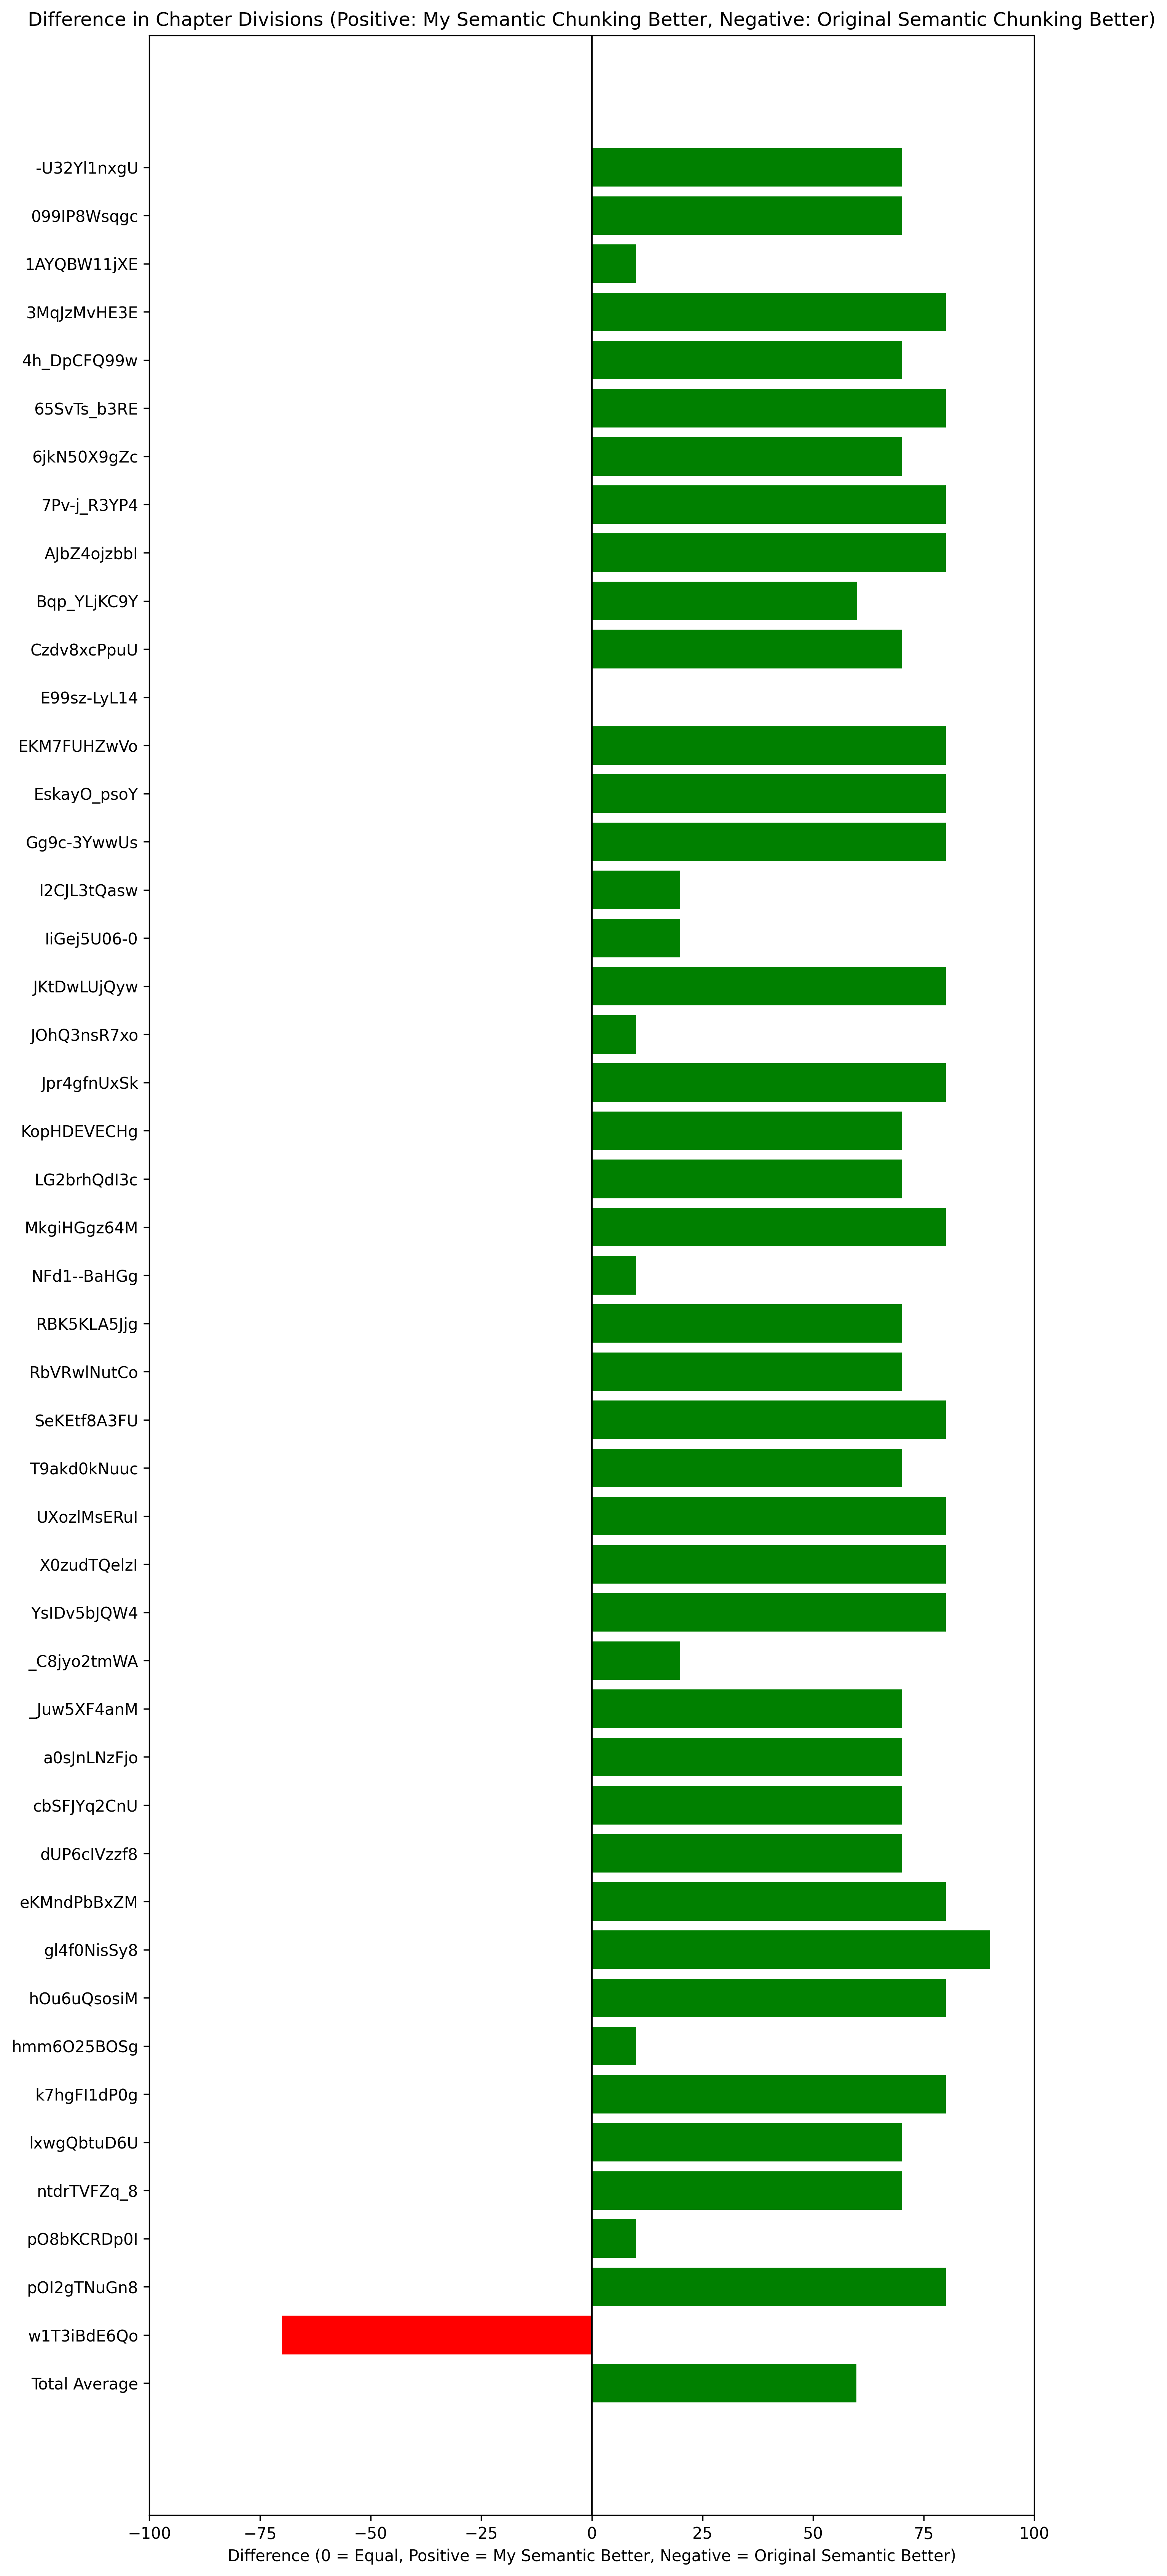

In [30]:
# Calculate the difference based on which division is better
def compute_difference(row):
    if row['which'] == 'A':
        return -row['rating_better']
    elif row['which'] == 'B':
        return row['rating_better']
    else:
        print(row)
        return 0


compare_semantic_chapter_division_df['difference'] = compare_semantic_chapter_division_df.apply(compute_difference, axis=1)

# Calculate the total average difference
total_average_difference = compare_semantic_chapter_division_df['difference'].mean()

# Create a DataFrame with the total average
compare_chapter_division_with_total_avg = pd.concat([
    compare_semantic_chapter_division_df,
    pd.DataFrame({'video_url': 'Total Average', 'difference': total_average_difference, 'arguments': ''}, index=[0]),
]).reset_index(drop=True)

# Reverse the order for plotting
keep_index_order = compare_chapter_division_with_total_avg.index.tolist()[::-1]
compare_chapter_division_with_total_avg = compare_chapter_division_with_total_avg.reindex(keep_index_order)

# Plotting
fig, ax = plt.subplots(figsize=(10, 0.6 * len(keep_index_order)), dpi=300)

bars = ax.barh(compare_chapter_division_with_total_avg['video_url'],
               compare_chapter_division_with_total_avg['difference'],
               color=['green' if diff > 0 else 'red' if diff < 0 else 'grey' for diff in
                      compare_chapter_division_with_total_avg['difference']])

ax.axvline(0, color='black', linewidth=1)
ax.set_title('Difference in Chapter Divisions (Positive: My Semantic Chunking Better, Negative: Original Semantic Chunking Better)')
ax.set_xlabel('Difference (0 = Equal, Positive = My Semantic Better, Negative = Original Semantic Better)')
ax.set_xlim(-100, 100)
plt.show()

In [38]:
import numpy as np
from scipy.stats import norm
from scipy import stats

equality_point = 0

t_stat, p_value = stats.ttest_1samp(compare_semantic_chapter_division_df['difference'].astype(float), equality_point)

print(f"T-statistic: {t_stat}, P-value: {p_value}")
alpha = 0.05
power = 0.8

mean_rating = compare_semantic_chapter_division_df['difference'].mean()

if p_value < alpha:
    print(f"Reject the null hypothesis: The mean rating is significantly different from {equality_point}.")
    if mean_rating > equality_point:
        print("Conclusion:")
        print(" My semantic chapter division is significantly better than the original semantic chapter division.")
        print(
            f" Semantic chapter division is around {(mean_rating - equality_point).round(2)}% better than human chapter division")
    else:
        print("Conclusion:")
        print(" My semantic chapter division is significantly worse than original semantic chapter division.")
        print(f" My semantic chapter division is {mean_rating.round(2)}% worse than original semantic chapter division")
else:
    print(
        f"Fail to reject the null hypothesis: The mean rating is not significantly different from {equality_point} = {mean_rating}.")
    print('Conclusion:')
    print(" No significant difference between my semantic chapter division and the original semantic chapter division.")

    # Calculate needed sample size in order to verify that we are not falsely accepting H0
    sigma = (equality_point - compare_semantic_chapter_division_df['difference']).std()
    delta = abs(equality_point - mean_rating)

    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)

    sample_size_req = (2 * (sigma ** 2) * (z_alpha + z_beta) ** 2) / (delta ** 2)
    sample_size_req = np.ceil(sample_size_req)

    print(f"Required sample size: {sample_size_req}")

    if sample_size_req > sample_size:
        print(f"Sample size not big enough: {sample_size_req} > {sample_size}")


T-statistic: 12.480246646766867, P-value: 3.2554704594564156e-16
Reject the null hypothesis: The mean rating is significantly different from 0.
Conclusion:
 My semantic chapter division is significantly better than the original semantic chapter division.
 Semantic chapter division is around 59.78% better than human chapter division


Step 4: Evaluate how much better/worse the semantic chapters are than the human chapters

In [26]:
compare_human_chapter_division_df = pd.DataFrame(columns=['video_url', 'rating_semantic_better', 'arguments'])

for video_url in video_urls:
    compare_chapter_division_per_video_data = {}

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        (human_chapters_transcript_df['video_url'] == video_url)
    ]
    transcript_text = ' '.join(human_chapters_transcript_per_video_df['chapter_text'].tolist())

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        human_chapters_transcript_df['video_url'] == video_url
    ]

    human_chapters_str = ''
    for idx, (_, chapter) in enumerate(human_chapters_transcript_per_video_df.iterrows()):
        human_chapters_str += f"Chapter {idx}:\nText: {chapter['chapter_text']}\n\n"

    semantic_chapter_transcript_per_video_df = semantic_chapter_df[
        semantic_chapter_df['video_url'] == video_url]

    semantic_chapters_str = ''
    for idx, (_, chapter) in enumerate(semantic_chapter_transcript_per_video_df.iterrows()):
        semantic_chapters_str += f"Chapter {idx}:\nText: {chapter['chapter_text']}\n\n"

    comparison_prompt = PromptTemplate(
        input_variables=['human_chapters', 'semantic_chapters', 'whole_transcript'],
        partial_variables={'format_instructions': output_parser_which.get_format_instructions()},
        template="""
    Given the entire transcript of a video and two different divisions into chapters (Division A and Division B), choose which division is better and rate how much better the chosen division is compared to the other from 0 to 100, where 0 means that both divisions are equally good, and 100 means the chosen division is much better than the other. Provide arguments why the rating is chosen.
    
    Entire Transcript:
    {whole_transcript}
    
    Division A:
    {human_chapters}
    
    Division B:
    {semantic_chapters}
    
    {format_instructions}
    """
    )
    
    # Compare the divisions
    try:
        comparison_response = (comparison_prompt | structured_model_which).invoke({
            "human_chapters": human_chapters_str,
            "semantic_chapters": semantic_chapters_str,
            "whole_transcript": transcript_text
        })
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_better': comparison_response.rating,
            'which': comparison_response.which_better,
            'arguments': comparison_response.arguments
        }
    except Exception as e:
        print(f"Error comparing divisions: {e}")
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_better': None,
            'which': '',
            'arguments': str(e)
        }
    compare_chapter_division_per_video_df = pd.DataFrame(compare_chapter_division_per_video_data, index=[0])
    print(f"Chapter division ratings for video '{video_url}':")
    total_semantic_better = compare_chapter_division_per_video_data["rating_better"]
    print(
        f"    Chapter division {compare_chapter_division_per_video_data['which']} is {total_semantic_better}% better than the other chapter division")
    print(f"    The reason for the rating is:\n{compare_chapter_division_per_video_data['arguments']}")
    print("-" * 100)
    compare_human_chapter_division_df = pd.concat(
        [compare_human_chapter_division_df, compare_chapter_division_per_video_df]).reset_index(
        drop=True)

Chapter division ratings for video '-U32Yl1nxgU':
    Chapter division B is 80% better than the other chapter division
    The reason for the rating is:
Division B is better because it groups related content more cohesively, making it easier to follow the logical progression of the lesson. For example, it keeps the entire problem statement and initial conditions in one chapter, and it groups the discussion of mechanical energy conservation and initial kinetic energy together. This helps maintain the flow of the lesson and reduces the cognitive load on the viewer. Division A, on the other hand, breaks the content into smaller, less coherent chunks, which can disrupt the understanding of the material. The rating of 80 reflects the significant improvement in clarity and coherence provided by Division B.
----------------------------------------------------------------------------------------------------
Chapter division ratings for video '099IP8Wsqgc':
    Chapter division B is 70% better 

Comparison between semantic chapter vs human chapter division

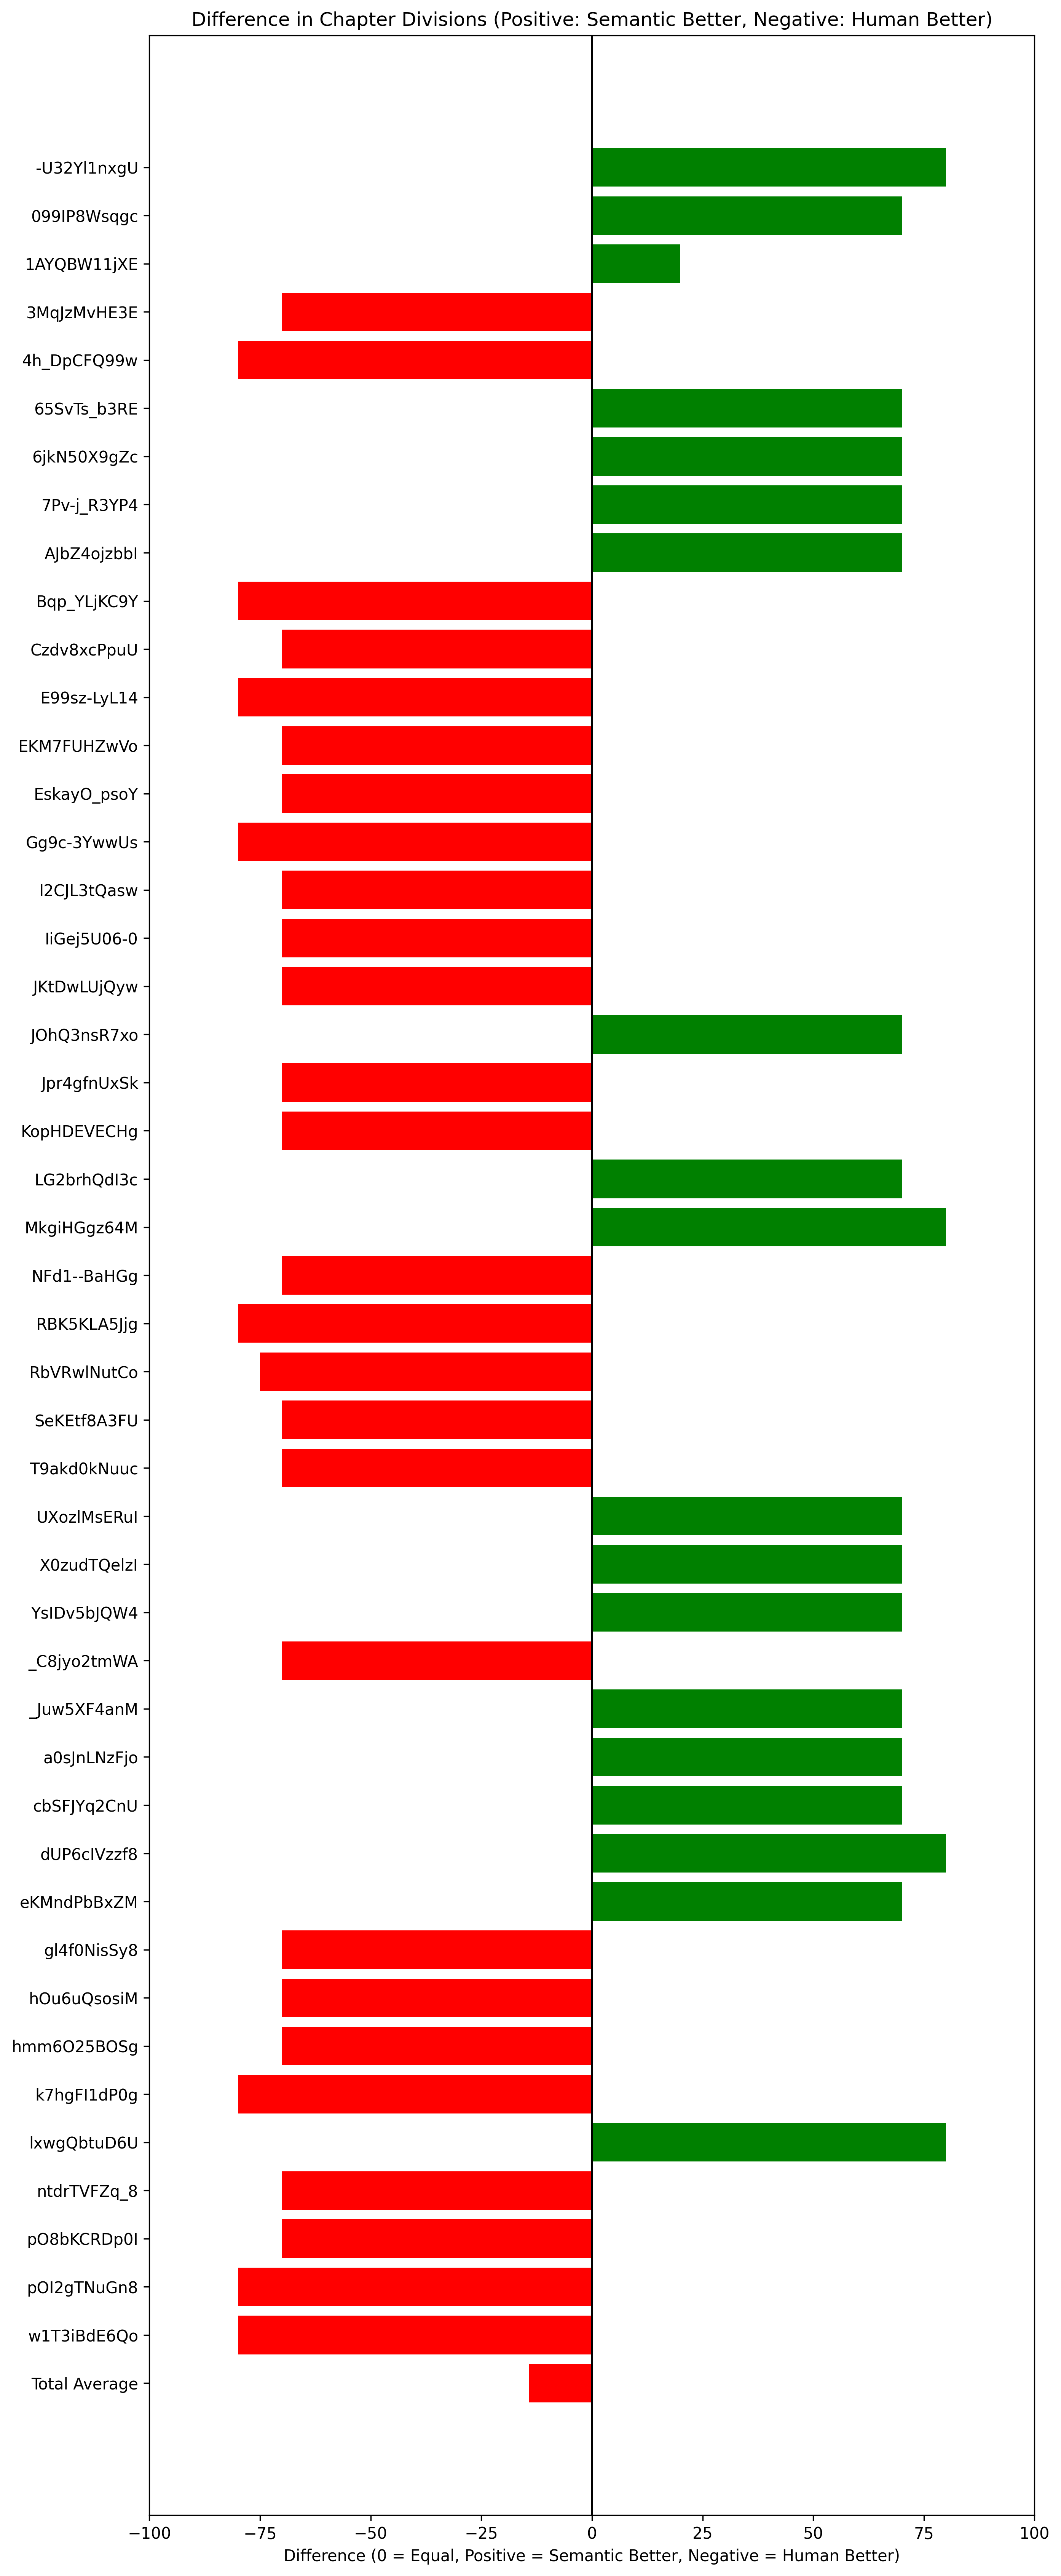

In [29]:
# Calculate the difference based on which division is better
def compute_difference(row):
    if row['which'] == 'A':
        return -row['rating_better']
    elif row['which'] == 'B':
        return row['rating_better']
    else:
        print(row)
        return 0  # In case of a tie or error


compare_human_chapter_division_df['difference'] = compare_human_chapter_division_df.apply(compute_difference, axis=1)

# Calculate the total average difference
total_average_difference = compare_human_chapter_division_df['difference'].mean()

# Create a DataFrame with the total average
compare_chapter_division_with_total_avg = pd.concat([
    compare_human_chapter_division_df,
    pd.DataFrame({'video_url': 'Total Average', 'difference': total_average_difference, 'arguments': ''}, index=[0]),
]).reset_index(drop=True)

# Reverse the order for plotting
keep_index_order = compare_chapter_division_with_total_avg.index.tolist()[::-1]
compare_chapter_division_with_total_avg = compare_chapter_division_with_total_avg.reindex(keep_index_order)

# Plotting
fig, ax = plt.subplots(figsize=(10, 0.6 * len(keep_index_order)), dpi=300)

bars = ax.barh(compare_chapter_division_with_total_avg['video_url'],
               compare_chapter_division_with_total_avg['difference'],
               color=['green' if diff > 0 else 'red' if diff < 0 else 'grey' for diff in
                      compare_chapter_division_with_total_avg['difference']])

ax.axvline(0, color='black', linewidth=1)
ax.set_title('Difference in Chapter Divisions (Positive: Semantic Better, Negative: Human Better)')
ax.set_xlabel('Difference (0 = Equal, Positive = Semantic Better, Negative = Human Better)')
ax.set_xlim(-100, 100)
plt.show()

In [37]:
import numpy as np
from scipy.stats import norm
from scipy import stats

equality_point = 0

t_stat, p_value = stats.ttest_1samp(compare_human_chapter_division_df['difference'].astype(float), equality_point)

print(f"T-statistic: {t_stat}, P-value: {p_value}")
alpha = 0.05
power = 0.8

mean_rating = compare_human_chapter_division_df['difference'].mean()

if p_value < alpha:
    print(f"Reject the null hypothesis: The mean rating is significantly different from {equality_point}.")
    if mean_rating > equality_point:
        print("Conclusion:")
        print(" Semantic chapter division is significantly better than human chapter division.")
        print(f" Semantic chapter division is around {(mean_rating - equality_point).round(2)}% better than human chapter division")
    else:
        print("Conclusion:")
        print(" Semantic chapter division is significantly worse than human chapter division.")
        print(f" Semantic chapter division is {mean_rating.round(2)}% worse than human chapter division")
else:
    print(f"Fail to reject the null hypothesis: The mean rating is not significantly different from {equality_point} = {mean_rating}.")
    print('Conclusion:')
    print(" No significant difference between semantic and human chapter division.")
    
    # Calculate needed sample size in order to verify that we are not falsely accepting H0
    # The mean is 50 - equal, any difference is 50 - value
    sigma = (equality_point - compare_human_chapter_division_df['difference']).std()
    delta = abs(equality_point - mean_rating)
    
    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)
    
    sample_size_req = (2 * (sigma ** 2) * (z_alpha + z_beta) ** 2) / (delta ** 2)
    sample_size_req = np.ceil(sample_size_req)
    
    print(f"Required sample size: {sample_size_req}")
    
    if sample_size_req > sample_size:
        print(f"Sample size not big enough: {sample_size_req} > {sample_size}")


T-statistic: -1.349967177497972, P-value: 0.18377813721561806
Fail to reject the null hypothesis: The mean rating is not significantly different from 0 = -14.23913043478261.
Conclusion:
 No significant difference between semantic and human chapter division.
Required sample size: 397.0
Sample size not big enough: 397.0 > 48
